<a href="https://colab.research.google.com/github/minako-aino/data-analysis-2023/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Знайомство з нейромережами

In [20]:
from google.colab import drive

import pandas as pd
import numpy as np

import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Embedding, SpatialDropout1D, Bidirectional, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Хід роботи:
## 1. Повнозв'язані нейронні мережі

Вирішіть завдання класифікації даних, з якими ви працювали в лабораторній № 1 за допомогою повнозв’язаної нейромережі прямого поширення (fully connected feed-forward network). Результати порівняйте з одержаними раніше.



In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


Завантажимо вже очищені дані із попередніх робіт:

In [19]:
# upload data
df = pd.read_csv('/content/drive/MyDrive/IPT masters/9 sem/Інтелектуальний аналіз даних/lab1/smoking_drinking_dataset_cleaned.csv')
df.head()

,Unnamed: 0,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,0,1,35,170,75,90.0,1.0,1.0,1.0,1.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,1
1,1,1,30,180,80,89.0,0.9,1.2,1.0,1.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,0
2,2,1,40,165,75,91.0,1.2,1.5,1.0,1.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,0
3,3,1,50,175,80,91.0,1.5,1.2,1.0,1.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,0
4,4,1,50,165,60,80.0,1.0,1.2,1.0,1.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,0


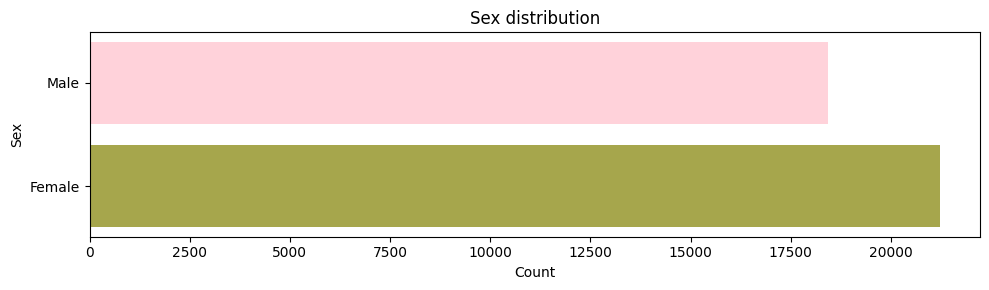

In [42]:
# see the distribution
plt.figure(figsize=(10, 3))
labels = ['Female', 'Male']
counts = df['sex'].value_counts().values
colors = ['olive', 'pink']
alphas = [0.7, 0.7]

plt.barh(labels, counts, color=colors, alpha=0.7)
plt.title('Sex distribution')
plt.xlabel('Count')
plt.ylabel('Sex')

plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim(0, df['sex'].value_counts().max() + 1000)
plt.tight_layout()

plt.yticks(labels, labels)
plt.show()

In [21]:
df.head()

,Unnamed: 0,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,0,1,35,170,75,90.0,1.0,1.0,1.0,1.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,1
1,1,1,30,180,80,89.0,0.9,1.2,1.0,1.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,0
2,2,1,40,165,75,91.0,1.2,1.5,1.0,1.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,0
3,3,1,50,175,80,91.0,1.5,1.2,1.0,1.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,0
4,4,1,50,165,60,80.0,1.0,1.2,1.0,1.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,0


In [22]:
# Normalization
scaler = MinMaxScaler()
scaler.fit(df)
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns=df.columns)

In [24]:
df = df.sample(frac = 0.2)

In [25]:
# Target is the same as it was
X = df.drop('sex', axis=1)
y = df['sex']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [37]:
model = Sequential(name="task1")

model.add(Dense(20, input_shape=(24,), activation = 'relu'))
model.add(Dense(50, activation = 'tanh'))
model.add(Dense(2,  activation = 'sigmoid'))

model.compile(loss="binary_crossentropy", metrics = ['accuracy'], optimizer = 'adam')
results = model.fit(X_train, y_train, epochs = 40)

Epoch 1/40
992/992 [==============================] - 6s 5ms/step - loss: 392.9495 - accuracy: 0.5101
Epoch 2/40
992/992 [==============================] - 3s 3ms/step - loss: 295.6366 - accuracy: 0.5134
Epoch 3/40
992/992 [==============================] - 4s 4ms/step - loss: 258.6035 - accuracy: 0.5179
Epoch 4/40
992/992 [==============================] - 3s 3ms/step - loss: 206.3742 - accuracy: 0.5210
Epoch 5/40
992/992 [==============================] - 3s 3ms/step - loss: 204.8371 - accuracy: 0.5228
Epoch 6/40
992/992 [==============================] - 3s 3ms/step - loss: 188.2542 - accuracy: 0.5377
Epoch 7/40
992/992 [==============================] - 3s 3ms/step - loss: 169.1225 - accuracy: 0.5365
Epoch 8/40
992/992 [==============================] - 4s 4ms/step - loss: 154.1401 - accuracy: 0.5401
Epoch 9/40
992/992 [==============================] - 6s 6ms/step - loss: 145.1769 - accuracy: 0.5454
Epoch 10/40
992/992 [==============================] - 4s 4ms/step - loss: 139.078

In [38]:
eval_results = model.evaluate(X_test, y_test, verbose=0)
print('Losses:', eval_results[0])
print('Accuracy:', eval_results[1])

Losses: 3.293438196182251
Accuracy: 0.7875157594680786


Результат із першої лабораторної роботи:
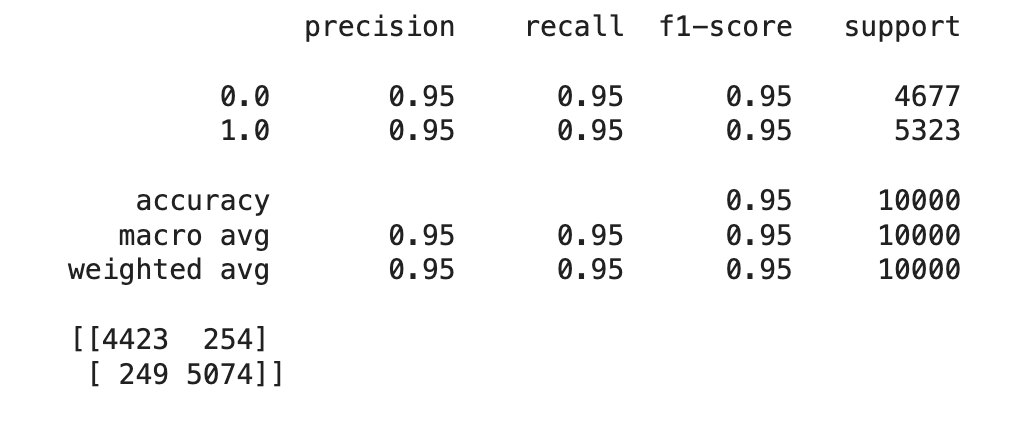

## 2. Згорткові нейронні мережі

Вирішіть завдання класифікації зображень за допомогою згорткової (convolutional) нейромережі (якщо в обраному датасеті класів забагато, достатньо залишити 3-5).

Обраний датасет: https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification

In [54]:
# upload
path = '/content/drive/MyDrive/IPT masters/9 sem/Інтелектуальний аналіз даних/lab3/images/'
categories = {"Cheetahs": 0, "Lions": 1}

data = []

for s, l in zip(categories.keys(), list(categories.values())):
    for r, d, f in os.walk(path + s):
        for file in f:
            if ".jpg" in file:
                data.append((os.path.join(s, file), l))

df = pd.DataFrame(data, columns=['file_name', 'label'])


Дізнаємось більше про датасет.

In [55]:
# shuffle to get more randomness
df = shuffle(df)

df = df.sample(frac=1).reset_index(drop=True)
df.head()

,file_name,label
0,Lions/eb551b1c169fe188.jpg,1
1,Cheetahs/775f869903916081.jpg,0
2,Lions/68bf461dd7b96ade.jpg,1
3,Lions/87c3f099efb2eff9.jpg,1
4,Cheetahs/dd1dddc3ed720109.jpg,0


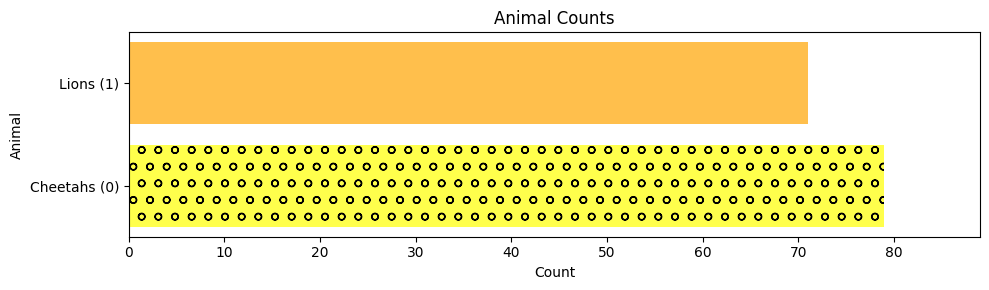

In [57]:
# see the distribution
plt.figure(figsize=(10, 3))
labels = ['Cheetahs (0)', 'Lions (1)']
counts = df['label'].value_counts().values
colors = ['yellow', 'orange']
hatches = ["o", None]
alphas = [0.7, 0.7]

plt.barh(labels, counts, color=colors, hatch=hatches, alpha=0.7)
plt.title('Animal Counts')
plt.xlabel('Count')
plt.ylabel('Animal')

plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim(0, df['label'].value_counts().max() + 10)
plt.tight_layout()

plt.yticks(labels, labels)
plt.show()


In [58]:
# verify
df.label.value_counts()

0    79
1    71
Name: label, dtype: int64

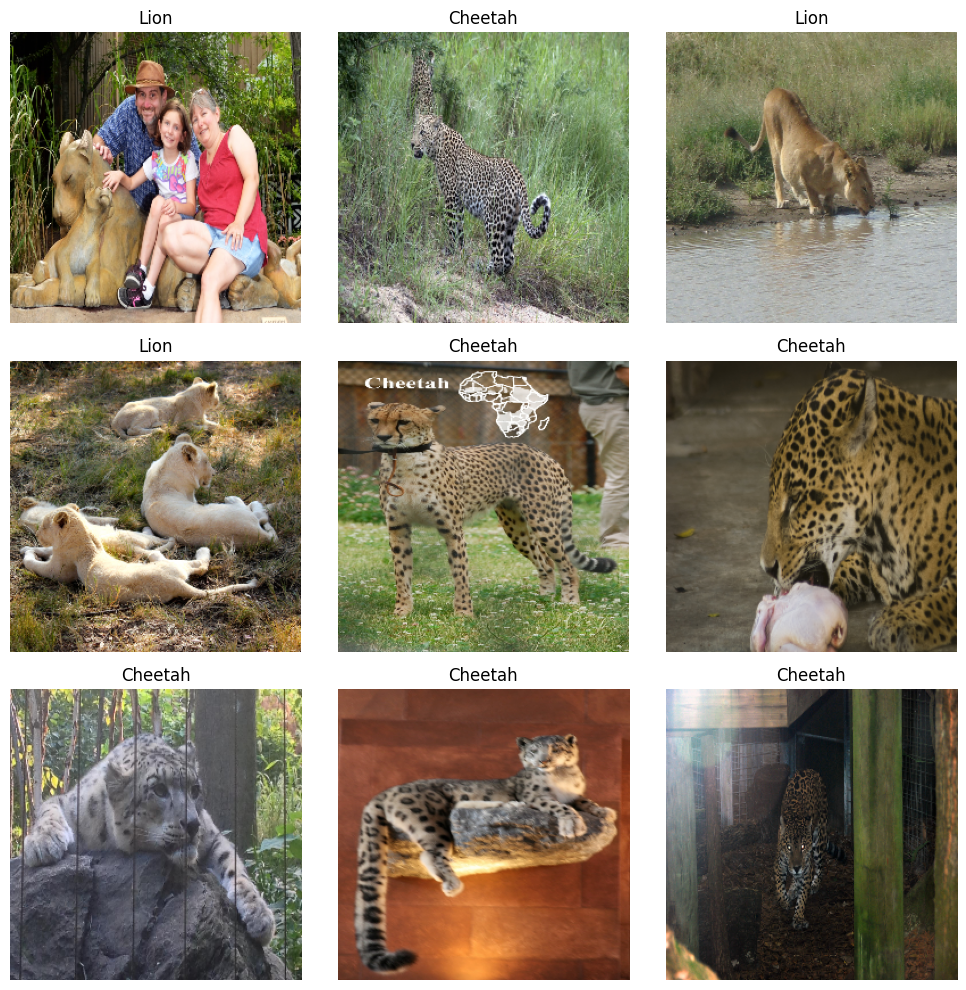

In [59]:
fig, img = plt.subplots(3, 3, figsize=(10, 10))

idx = 0
for i in range(3):
    for j in range(3):
        label = df.label[idx]
        file_path = os.path.join(path, df.file_name[idx])

        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))

        img[i,j].imshow(image)
        img[i,j].set_title(f"{'Lion' if label == 1 else 'Cheetah'}")
        img[i,j].axis('off')

        idx = idx+1

plt.tight_layout()
plt.show()

Дізнавшись більше про датасет, можемо завантажувати його для подальшої роботи:

In [ ]:
# upload
path = '/content/drive/MyDrive/IPT masters/9 sem/Інтелектуальний аналіз даних/lab3/images/'
categories = {"Cheetahs": 0, "Lions": 1}

X = [] # image
y = [] # label

for category, label in zip(categories.keys(), list(categories.values())):
    for r, d, f in os.walk(path + category):
        for file in f:
            if ".jpg" in file:
              image_path = path + category + '/' + file
              image = cv2.imread(image_path)
              image = cv2.resize(image, (100, 100))
              image = image / 255.0
              X.append(image)
              y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
# Split into parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

Навчання:

In [ ]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

model = Sequential()
model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(X_train, y_train, batch_size=50, epochs=20)

Epoch 1/20
3/3 [==============================] - 10s 1s/step - loss: 9.1218 - accuracy: 0.5333
Epoch 2/20
3/3 [==============================] - 5s 1s/step - loss: 3.0226 - accuracy: 0.4667
Epoch 3/20
3/3 [==============================] - 6s 2s/step - loss: 1.2011 - accuracy: 0.4667
Epoch 4/20
3/3 [==============================] - 8s 2s/step - loss: 0.6739 - accuracy: 0.5833
Epoch 5/20
3/3 [==============================] - 5s 1s/step - loss: 0.6597 - accuracy: 0.5333
Epoch 6/20
3/3 [==============================] - 5s 1s/step - loss: 0.6393 - accuracy: 0.5583
Epoch 7/20
3/3 [==============================] - 8s 2s/step - loss: 0.6190 - accuracy: 0.9167
Epoch 8/20
3/3 [==============================] - 6s 1s/step - loss: 0.5883 - accuracy: 0.8833
Epoch 9/20
3/3 [==============================] - 5s 1s/step - loss: 0.5379 - accuracy: 0.8667
Epoch 10/20
3/3 [==============================] - 6s 2s/step - loss: 0.4678 - accuracy: 0.8417
Epoch 11/20
3/3 [==============================]

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Losses:', results[0])
print('Accuracy:', results[1])

Losses: 0.7153685092926025
Accuracy: 0.7333333492279053


## 3. Рекурентні нейронні мережі

Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі. Результати порівняйте з одержаними раніше.

Аналогічно до першого пункту, заванажимо вже очищений і опрацьований датасет із попередньої роботи:

In [45]:
# Load some data
txt = pd.read_csv('/content/drive/MyDrive/IPT masters/9 sem/Інтелектуальний аналіз даних/lab2/APPLE_iPhone_SE_clean.csv')

# reshuffle - just in case
txt = txt.sample(frac=1).reset_index(drop=True)
txt.head()

,Ratings,Reviews
0,1,stopped working even using 1 monthread
1,1,phone serve basic function receiving making ca...
2,4,awesome love read
3,1,normal use twice day charge used apple models ...
4,5,awesomeread


In [50]:
X = txt['Reviews']
y = txt['Ratings']

y = pd.get_dummies(y)

# finish processing
X = X.apply(lambda text: re.sub(r"\s+", " ", re.sub(r"[^A-Za-z]", " ", text)).lower())
X = X.apply(lambda text: ' '.join(x for x in text.split() if len(x) > 2))

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
# Tokenization part
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# defining max length
a = []
for i in X_train:
    a.append(len(i))
maxlen = int(np.ceil(np.mean(a)))

# pad sequences of integers
X_train_padded = pad_sequences(X_train, maxlen=maxlen)
X_test_padded = pad_sequences(X_test, maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

In [52]:
# prepare model
model = Sequential()
model.add(Embedding(vocab_size, 200, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_padded, y_train, epochs=20)

Epoch 1/20
243/243 [==============================] - 16s 51ms/step - loss: 0.3125 - accuracy: 0.6979
Epoch 2/20
243/243 [==============================] - 4s 17ms/step - loss: 0.2563 - accuracy: 0.7241
Epoch 3/20
243/243 [==============================] - 4s 16ms/step - loss: 0.2205 - accuracy: 0.7712
Epoch 4/20
243/243 [==============================] - 5s 21ms/step - loss: 0.1859 - accuracy: 0.8166
Epoch 5/20
243/243 [==============================] - 3s 12ms/step - loss: 0.1606 - accuracy: 0.8454
Epoch 6/20
243/243 [==============================] - 2s 10ms/step - loss: 0.1414 - accuracy: 0.8678
Epoch 7/20
243/243 [==============================] - 2s 8ms/step - loss: 0.1260 - accuracy: 0.8795
Epoch 8/20
243/243 [==============================] - 3s 13ms/step - loss: 0.1143 - accuracy: 0.8921
Epoch 9/20
243/243 [==============================] - 3s 14ms/step - loss: 0.1070 - accuracy: 0.8973
Epoch 10/20
243/243 [==============================] - 3s 10ms/step - loss: 0.1007 - accura

In [53]:
eval_results = model.evaluate(X_test, y_test, verbose=0)
print('Losses:', eval_results[0])
print('Accuracy:', eval_results[1])

Losses: 0.0732043981552124
Accuracy: 0.931016743183136


Результат із другої лабораторної роботи:
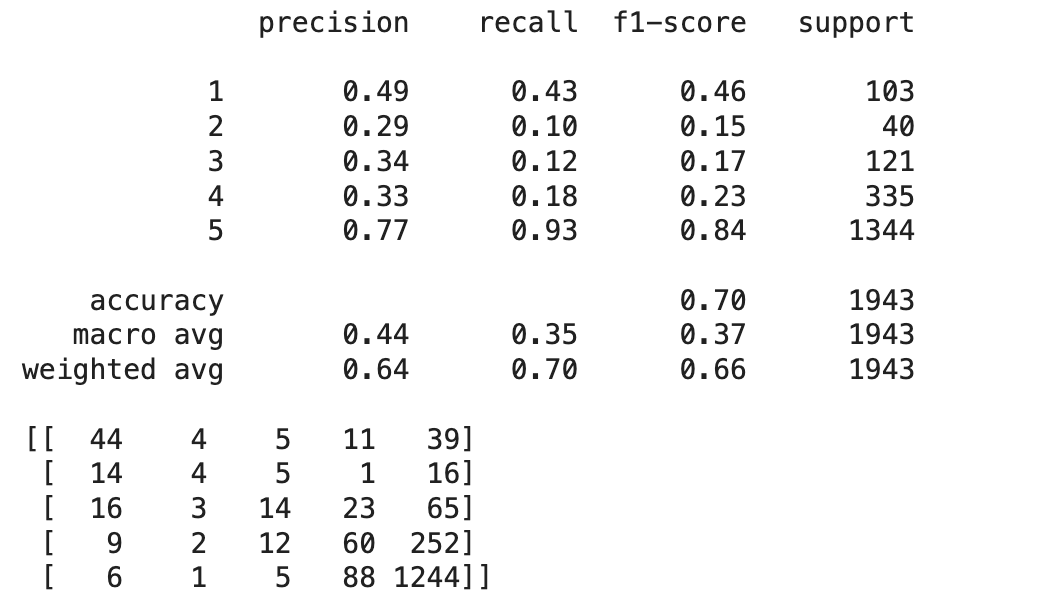